## Demo for Pytorch implementation of baseline

In [22]:
import sys

# Add main code-base to path
sys.path.append('../')

from data import *
from model.baseline import ImgSegRefExpModel
from model.resnet_exp import ResImgSeg, ResImgSegDeconved
import torch


import sys
import skimage.io
import numpy as np
import tensorflow as tf
import json
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# trained model
pretrained_model_file = "./project_models_upsampler_model_dict_ep_1_iter_1000.pt"
vocab_file = './vocabulary_referit.txt'

In [25]:
# Load vocabulary
vocab_dict = load_vocab_dict_from_file(vocab_file)

# Device
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

# Load model and weights
# model = ImgSegRefExpModel(mlp_hidden=500, vocab_size=8803, emb_size=1000, lstm_hidden_size=1000)
# model = ResImgSeg(mlp_hidden=500, vocab_size=8803, emb_size=1000, lstm_hidden_size=1000)
model = ResImgSegDeconved(mlp_hidden=500, vocab_size=8803, emb_size=1000, lstm_hidden_size=1000)



pre_trained = torch.load(pretrained_model_file)
model.load_state_dict(pre_trained)

model.to(device)

print(device)

initializing LSTM/GRU weight  weight_ih_l0
initializing LSTM/GRU weight  weight_hh_l0
bias init bias_ih_l0
bias init bias_hh_l0
init conv
init conv
init conv
init conv
init conv
init conv
init conv
cuda:0


In [26]:
set(model.state_dict().keys()).difference(set(pre_trained.keys()))

set()

### Run on sample image

In [33]:
# input image and query text
im_file = './38100.jpg'
query = 'sky above the bridge'

# im_file = "./37902.jpg"
# query = 'man'

In [34]:
# Load the model
# Model Param
T = 20
N = 1
input_H = 512; featmap_H = (input_H // 32)
input_W = 512; featmap_W = (input_W // 32)
num_vocab = 8803
embed_dim = 1000
lstm_dim = 1000
mlp_hidden_dims = 500

channel_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)

# Run on the input image and query text
text_seq_val = np.zeros((T, N), dtype=np.float32)
imcrop_val = np.zeros((N, input_H, input_W, 3), dtype=np.float32)

# Preprocess image and text
im = skimage.io.imread(im_file)

# Makes it uint8
processed_im = skimage.img_as_ubyte(resize_and_pad(im, input_H, input_W))
print(processed_im.dtype)

imcrop_val[0, :] = processed_im.astype(np.float32) - channel_mean
print(imcrop_val.dtype)

# preprocess sentence pads 0's before the phrase. flipping it ruins the output
text_seq_val[:, 0] = preprocess_sentence(query, vocab_dict, T)
print(text_seq_val.dtype)
print (text_seq_val)

imcrop_val = torch.Tensor(imcrop_val).permute(0, 3, 1, 2) 
text_seq_val = torch.LongTensor(text_seq_val).t() 

uint8
float32
float32
[[  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [152.]
 [244.]
 [  7.]
 [413.]]


In [35]:
print(imcrop_val.shape)
print (text_seq_val)
print(text_seq_val.shape)

torch.Size([1, 3, 512, 512])
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0, 152, 244,   7, 413]])
torch.Size([1, 20])


In [36]:
# Forward pass to get response map
output_mask = model((imcrop_val.to(device), text_seq_val.to(device)))

print("Mask shape", output_mask.shape)
output_mask = output_mask.squeeze(0)
output_mask = output_mask.squeeze(0)
print("Mask shape squeezed", output_mask.shape)

# Final prediction
prediction = resize_and_crop(output_mask.cpu().detach().numpy() > 0, * im.shape[:2]).astype(np.bool)

Mask shape torch.Size([1, 1, 512, 512])
Mask shape squeezed torch.Size([512, 512])


In [37]:
prediction

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

query text = 'sky above the bridge'


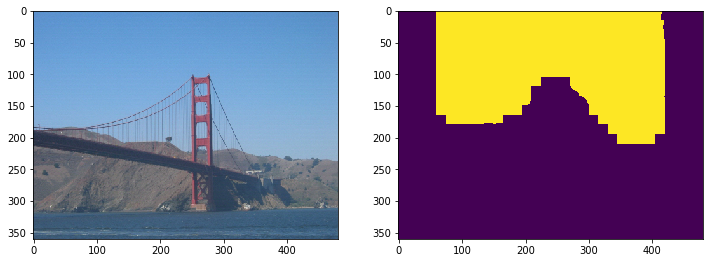

In [38]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.imshow(prediction)

print("query text = '%s'" % query)

## Torch re-write

In [ ]:
# input image and query text
im_file = './37902.jpg'
query = 'sky above the bridge'



# Load the model
# Model Param
T = 20
N = 1
input_H = 512; featmap_H = (input_H // 32)
input_W = 512; featmap_W = (input_W // 32)
num_vocab = 8803
embed_dim = 1000
lstm_dim = 1000
mlp_hidden_dims = 500


# Preprocess image and text
im = skimage.io.imread(im_file)

# Makes it uint8
processed_im = skimage.img_as_ubyte(resize_and_pad(im, input_H, input_W))
print(processed_im.dtype)

In [ ]:
print(im.shape)
print(processed_im.shape)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.imshow(processed_im)



In [ ]:
processed_im.shape

In [ ]:
# resize re
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
from PIL import Image
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torch.optim import lr_scheduler

import  PIL


def resize_recrop_torch(img, input_h, input_w):
    _, im_h, im_w = img.size()
    
    # Resize and crop im to input_h x input_w size
    scale = max(input_h / im_h, input_w / im_w)
    resized_h = int(np.round(im_h * scale))
    resized_w = int(np.round(im_w * scale))
    crop_h = int(np.floor(resized_h - input_h) / 2)
    crop_w = int(np.floor(resized_w - input_w) / 2)

    print(crop_h, crop_w)
    trf = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize([resized_w, resized_h], interpolation=1),
                              transforms.CenterCrop((resized_w - 2*crop_w, resized_h - 2*crop_h))])
    if trf:
        img = trf(img)
        
    return img

def resize_pad_torch(file_name, input_h, input_w):    
    img_name = os.path.join(file_name)
    img = Image.open(img_name)
    img = img.convert('RGB')
    
    im_h, im_w = img.size
    print(im_h, im_w)
    
    scale = min(input_h / im_h, input_w / im_w)
    resized_h = int(np.round(im_h * scale))
    resized_w = int(np.round(im_w * scale))
    print(resized_h, resized_w)

    pad_h = int(np.floor(input_h - resized_h) / 2)
    pad_w = int(np.floor(input_w - resized_w) / 2)

    print(pad_h, pad_w)
    
    trf = transforms.Compose([transforms.Resize([resized_w, resized_h], interpolation=1),
                              transforms.Pad((pad_h, pad_w), fill=0, padding_mode='constant'),
                              transforms.Resize([input_w, input_h], interpolation=1),
                              transforms.ToTensor()])
    if trf:
        img = trf(img)
    
    return img

In [ ]:
torch_im = resize_pad_torch(im_file, 512, 512)
torch_im.size

In [ ]:
torch_im.shape

In [ ]:
torch_im_pil = transforms.ToPILImage()(torch_im)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.imshow(torch_im_pil)

In [ ]:
torch_im_recrop = resize_recrop_torch(torch_im, 480, 360)
torch_im_recrop.size

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.imshow(torch_im_recrop)


In [ ]:
file = open("./25_1.mat", encoding= "utf-8")
file.readlines()
# torch_im = resize_pad_torch("./25_1.mat", 512, 512)
